# Demo of bmtool chemical synaptic tuner
By Gregory Glickert

First we must define some general settings and the settings for the connection we would like to tune. Below is an example of what this could look like for excitatory and inhibitory connections. Currently all of these settings, but the ones in the spec_syn_param are needed in order to use the tuner. You can copy all of the general_settings as these should be general enough to use for any case. If you dont include the general settting than by default it will use these settings. The spec_settings are going to depend on your exact use case and connection type. 

In [ ]:
general_settings = {
    'vclamp': True, # if vclamp should start on or off used mostly for singleEventv
    'rise_interval': (0.1, 0.9), #10-90%
    'tstart': 500., # when the singleEvent should start
    'tdur': 100.,    # Dur of sim after single synaptic event has occured
    'threshold': -15., #threshold for spike in mV
    'delay': 1.3, # netcon delay
    'weight': 1., # netcon weight
    'dt': 0.025, # simulation dt
    'celsius': 20 # temp of sim
}

conn_type_settings = {
    'Fac2FSI': { # facilitating synapse 
        'spec_settings': {
            'post_cell': 'FSI_Cell', 
            'vclamp_amp' : -70., # voltage clamp amps
            'sec_x': 0.5, # location of synapse
            'sec_id': 1,  # location of synapse 
            "level_of_detail": "AMPA_NMDA_STP", # name of mechanism from the modfile
        },
        'spec_syn_param': { # synaptic parameters from modfile 
            'initW': 0.76,
            'tau_r_AMPA': 0.45,
            'tau_d_AMPA': 7.5,
            'Use': 0.13,
            'Dep': 0.,
            'Fac': 200.
        },
    },
    'Dep2FSI': { # depressing synapse
        'spec_settings': {
            'post_cell': 'FSI_Cell',
            'vclamp_amp': -55,
            'sec_x': 0.5,
            'sec_id':0,
            "level_of_detail": "GABA_A_STP",
        },
        'spec_syn_param': {
            'initW': 20,
            'tau_r_GABAA': 0.9,
            'tau_d_GABAA': 15,
            'e_GABAA':-75,
            'Use': 0.4,
            'Dep': 190.,
            'Fac': 0.
        },
    },

}

Then the modfiles must be compiled in order for the tuner to work properly 

In [2]:
import os

# if already compiled then lets delete the folder and force a recompile
if os.path.isdir('modfiles/x86_64'):
    os.system("rm -rf modfiles/x86_64 ")
# compile the mod files
if not os.path.isdir("modfiles/x86_64"):
    os.chdir('modfiles')
    os.system("nrnivmodl")
    os.chdir("..")

/Users/gregglickert/miniconda3/envs/bmtk/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set


/usr/bin/xcrun
/Users/gregglickert/Documents/GitHub/bmtool/docs/examples/notebooks/synapses/synaptic_tuner/modfiles
Mod files: "./AMPA_NMDA_STP.mod" "./GABA_A_STP.mod" "./Gfluct.mod" "./cadad.mod" "./cal2.mod" "./can_mig.mod" "./exp2syn_stp.mod" "./gap.mod" "./h_kole.mod" "./imCA3.mod" "./kBK.mod" "./kap_BS.mod" "./kdmc_BS.mod" "./kdrCA3.mod" "./kdr_BS.mod" "./kdrinter.mod" "./leak.mod" "./nainter.mod" "./napCA3.mod" "./natCA3.mod" "./nax_BS.mod" "./vecevent_coreneuron.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.dylib
Successfully created arm64/special


## initialize tuner
Now we can initialize the synaptic tuner. You must call the SingleEvent method before using the interactiveTuner. When initializing you will have to change a few arguments depending on your use case. other_vars_to_record can be any variable in your synaptic mechanism, while slider_vars can be any range variable you wish to tune in the synapse. If the variable is not defined in the spec_syn_param than the tuner will get the value from the mechanism and try to set up some sliders to tune it.

In [3]:
mechanisms_dir = 'modfiles'
templates_file = 'templates.hoc'
#json_folder_path = os.path.join('..', 'Model-Parameters' , 'components', 'synaptic_models','synapses_M1_match')
# Initialize our tuner
from bmtool.synapses import SynapseTuner
tuner = SynapseTuner(mechanisms_dir=mechanisms_dir, # where x86_64 is located
                    templates_dir=templates_file, # where the neuron templates are located
                    conn_type_settings=conn_type_settings, # dict of connection settings
                    general_settings = general_settings, # dict of general settings
                    connection = 'Fac2FSI', # key in connection settings for which connection you want to tune
                    #json_folder_path=json_folder_path, # If your network uses json files the path can be set to update the connection settings based on the keys and values in the json
                    current_name = 'i', # name of current variable in synapase
                    other_vars_to_record = ['record_Pr', 'record_use'], # Other synaptic variables you wish to record besides the normal ones
                    slider_vars=['initW','Dep','Fac','Use','tau_r_AMPA','tau_d_AMPA']) # Range variables you want to tune to adjust synaptic response.


--No graphics will be displayed.


## SingleEvent 
The SingleEvent method will run a short pulse and then print out the synaptic properties for the synapse.  

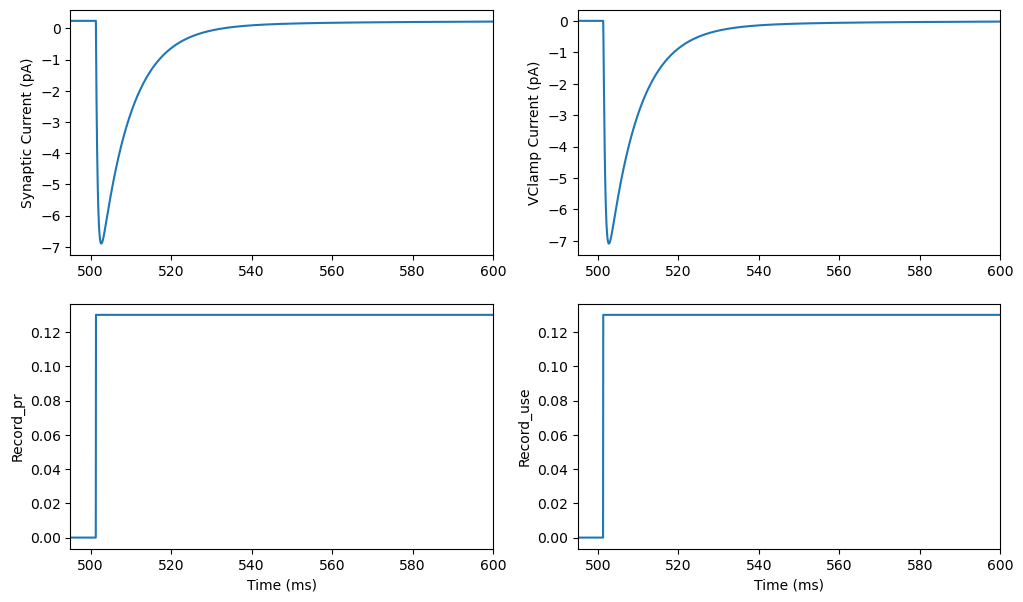

('baseline', -0.0002407732493736603)
('sign', -1.0)
('latency', 1.35)
('amp', 0.007084197529025005)
('rise_time', 0.7000000000000001)
('decay_time', 8.15559456633245)
('half_width', 8.275)
Current Integral in pA*ms: 73.67


In [4]:
tuner.SingleEvent()

## InteractiveTuner
The InteractiveTuner will deliver an input to the cell at a desired weight and frequency. The frequency by default will be 8 spikes then a 250ms delay and then 4 more spikes. 

Paired-pulse ratio is (Avg 2nd pulse - Avg 1st pulse) ÷ 90th percentile amplitude.

Induction is (Avg (6th, 7th, 8th pulses) - Avg 1st pulse) ÷ 90th percentile amplitude. 

Recovery is (Avg (9th, 10th, 11th, 12th pulses) - Avg (1st, 2nd, 3rd, 4th pulses)) ÷ 90th percentile amplitude

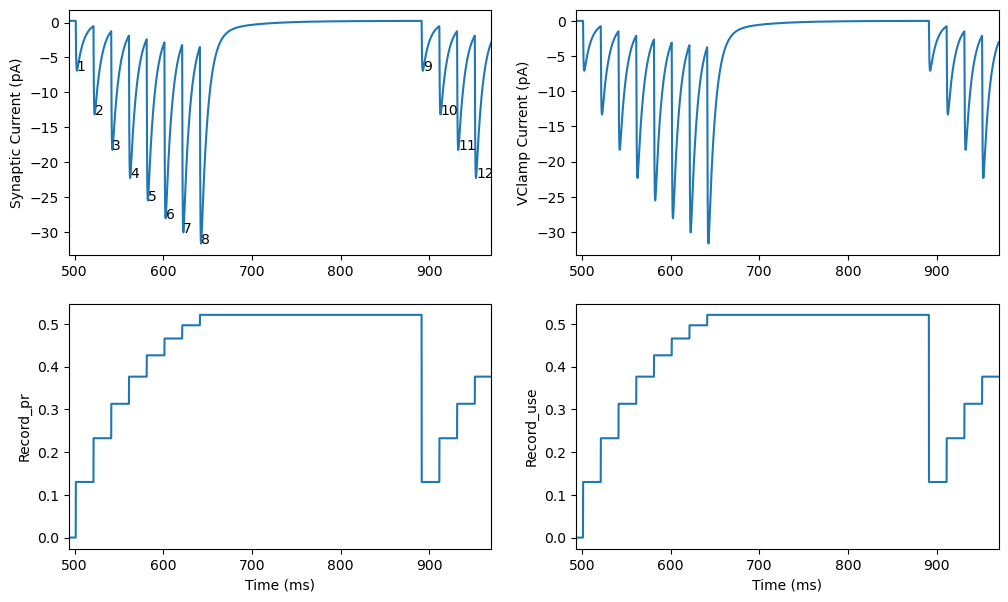


Short Term Plasticity Results for 50Hz with 250 Delay
PPR: Above 1 is facilitating, below 1 is depressing.
Induction: Above 0 is facilitating, below 0 is depressing.
Recovery: A measure of how fast STP decays.

Paired Pulse Response (PPR)
Calculation: 2nd pulse / 1st pulse
Values: ([[13.16]]) / ([[6.89]]) = [[1.91]]

Induction
Calculation: (avg(6th, 7th, 8th pulses) - 1st pulse) / max amps
Values: avg([[28.  , 30.02, 31.62]]) - [[6.89]] / [31.62]
([29.88]) - ([6.89]) / [31.62] = 0.727

Recovery
Calculation: (avg(9th, 10th, 11th, 12th pulses) - avg(1st to 4th pulses)) / max amps
Values: avg([[ 6.9 , 13.16, 18.21, 22.25]]) - avg([[ 6.89, 13.16, 18.21, 22.24]]) / [31.62]
([15.13]) - ([15.13]) / [31.62] = 0.000




In [5]:
tuner.InteractiveTuner()

## Frequency reponse
We can also see how the STP parameters vary with different train frequencies 

Analyzing frequencies:   0%|          | 0/16 [00:00<?, ?it/s]

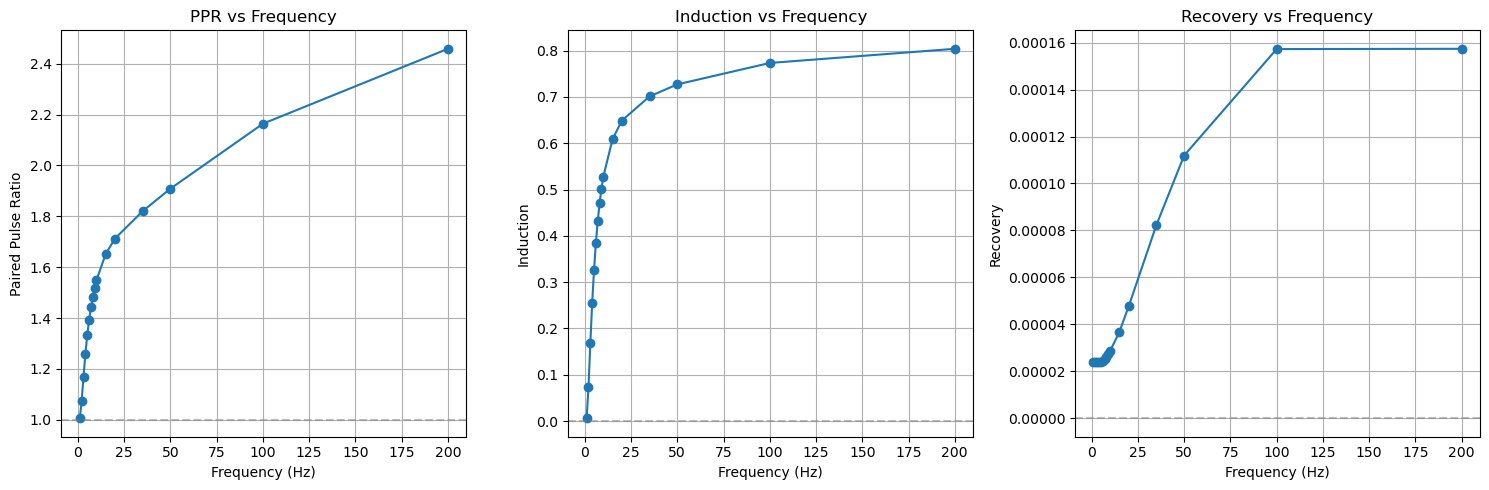

In [6]:
results = tuner.stp_frequency_response(log_plot=False)

## SynapseOptimizer
If we don't feel like tuner by hand we can also try to optimize an output of our model. In this example we will optimize and find the best STP parameters that give the induction and paired pulse response we want. Something to note is that the optimizer does not know what the trace should look like and only knows the features. So it might get some wild trace that happens to work. Also if you are using the random init_guess and don't like the voltage trace then run it again. The seed is different each time so the optimization will be different and can result in a better fit.

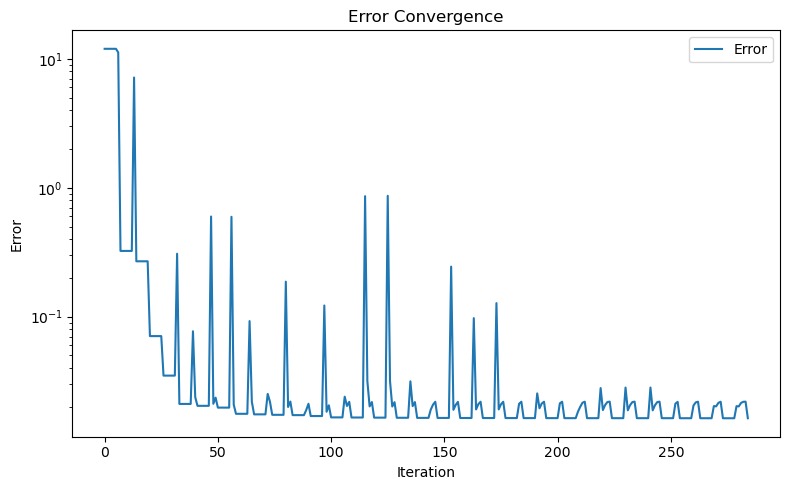

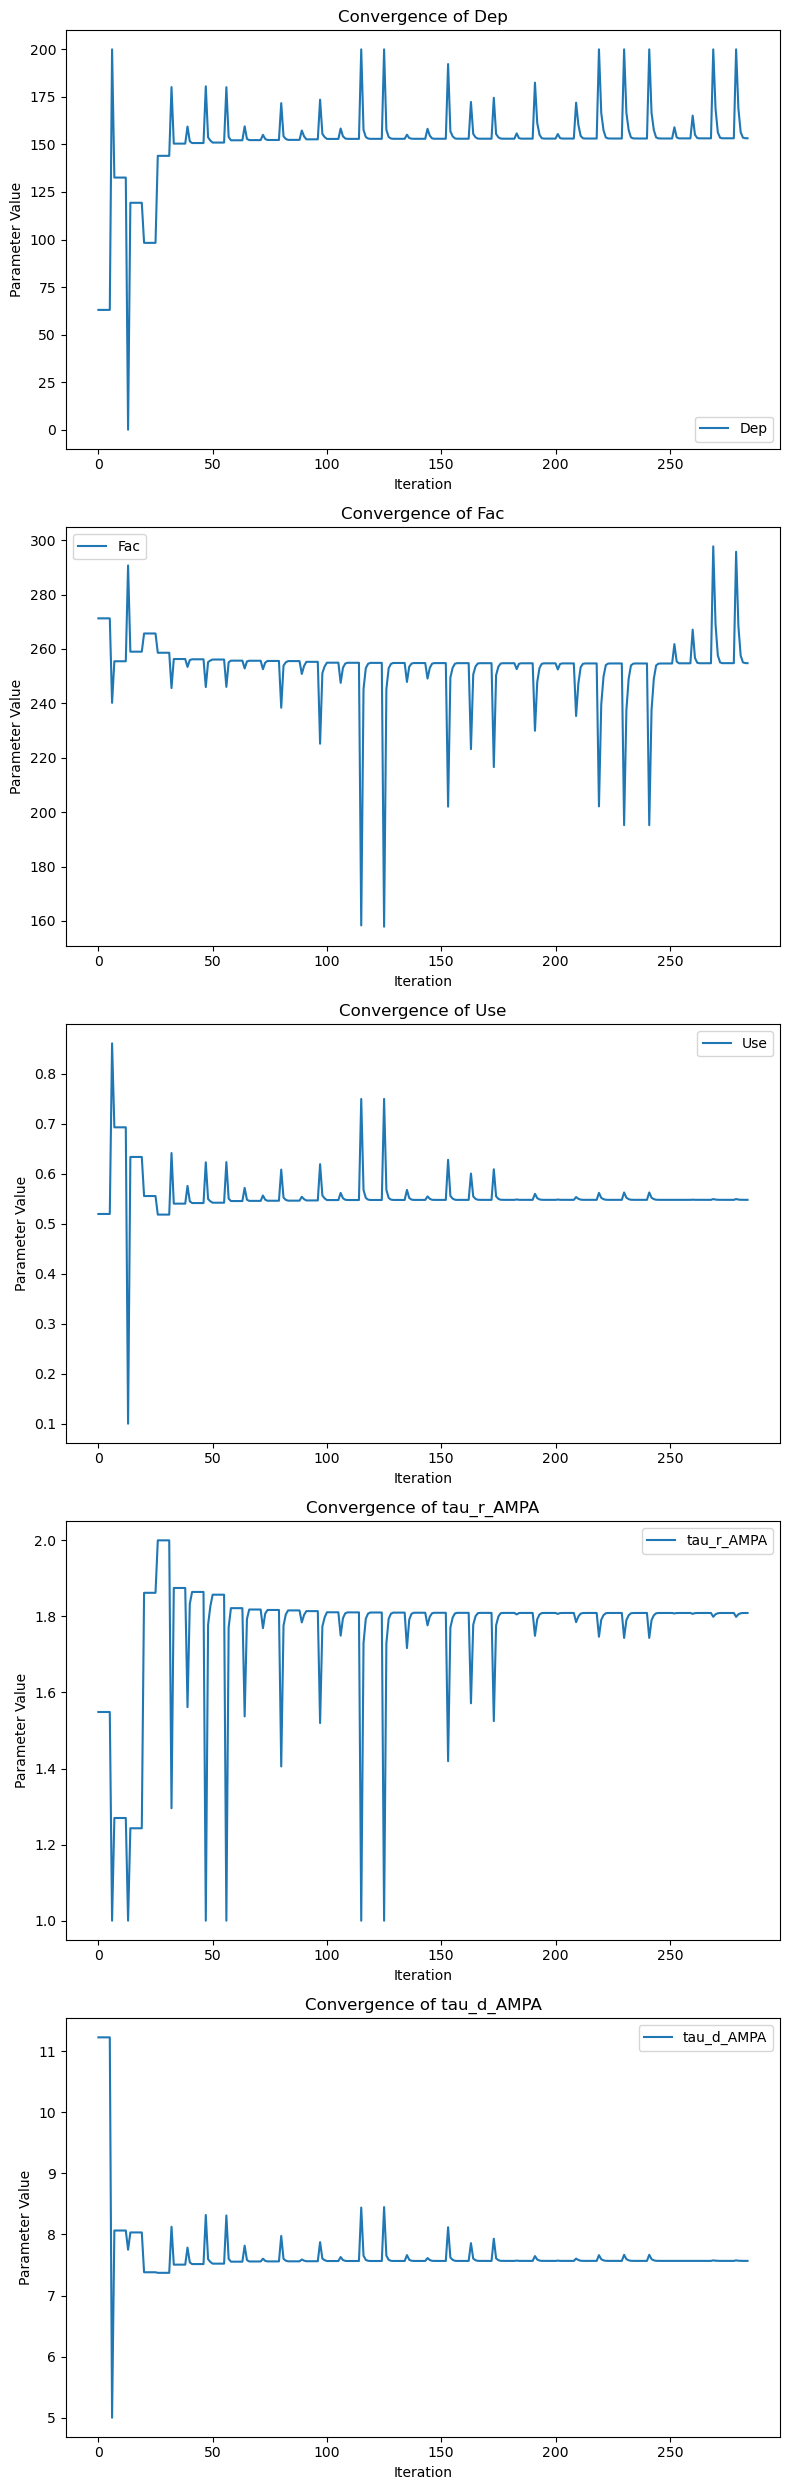

Optimization Results:
Final Error: 1.63e-02

Target Metrics:
induction: -0.747 (target: -0.750)
ppr: 0.846 (target: 0.800)
recovery: 0.000 (target: 0.000)
max_amplitude: 29.786 (target: 25.000)
rise_time: 1.900 (target: 2.000)
decay_time: 8.992 (target: 9.000)

Optimal Parameters:
Dep: 153.239
Fac: 254.783
Use: 0.548
tau_r_AMPA: 1.809
tau_d_AMPA: 7.568


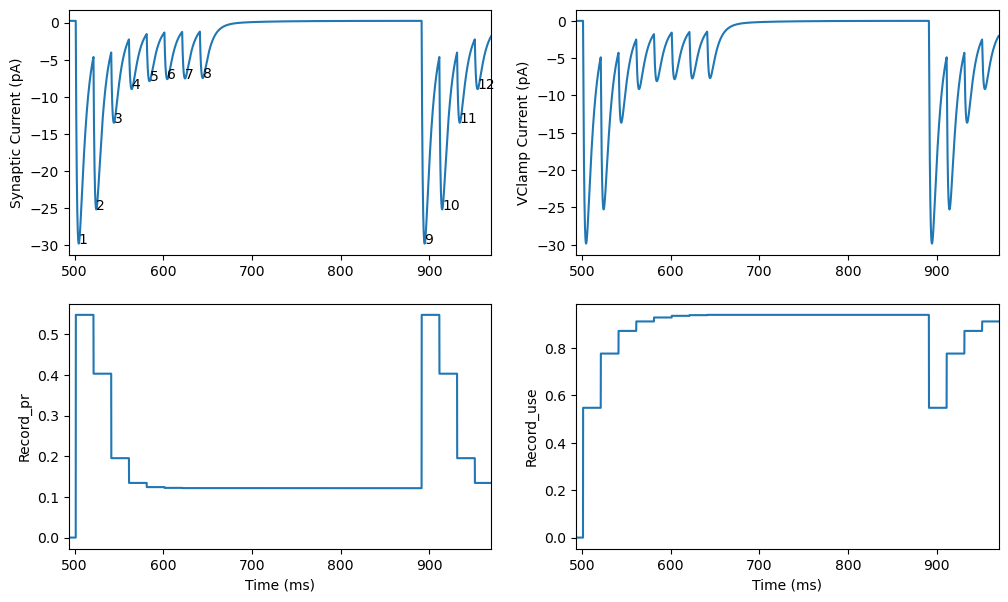


Short Term Plasticity Results for 50Hz with 250 Delay
PPR: Above 1 is facilitating, below 1 is depressing.
Induction: Above 0 is facilitating, below 0 is depressing.
Recovery: A measure of how fast STP decays.

Paired Pulse Response (PPR)
Calculation: 2nd pulse / 1st pulse
Values: ([[25.18]]) / ([[29.78]]) = [[0.85]]

Induction
Calculation: (avg(6th, 7th, 8th pulses) - 1st pulse) / max amps
Values: avg([[7.62, 7.53, 7.48]]) - [[29.78]] / [29.79]
([7.54]) - ([29.78]) / [29.79] = -0.747

Recovery
Calculation: (avg(9th, 10th, 11th, 12th pulses) - avg(1st to 4th pulses)) / max amps
Values: avg([[29.79, 25.19, 13.49,  8.96]]) - avg([[29.78, 25.18, 13.49,  8.96]]) / [29.79]
([19.36]) - ([19.36]) / [29.79] = 0.000




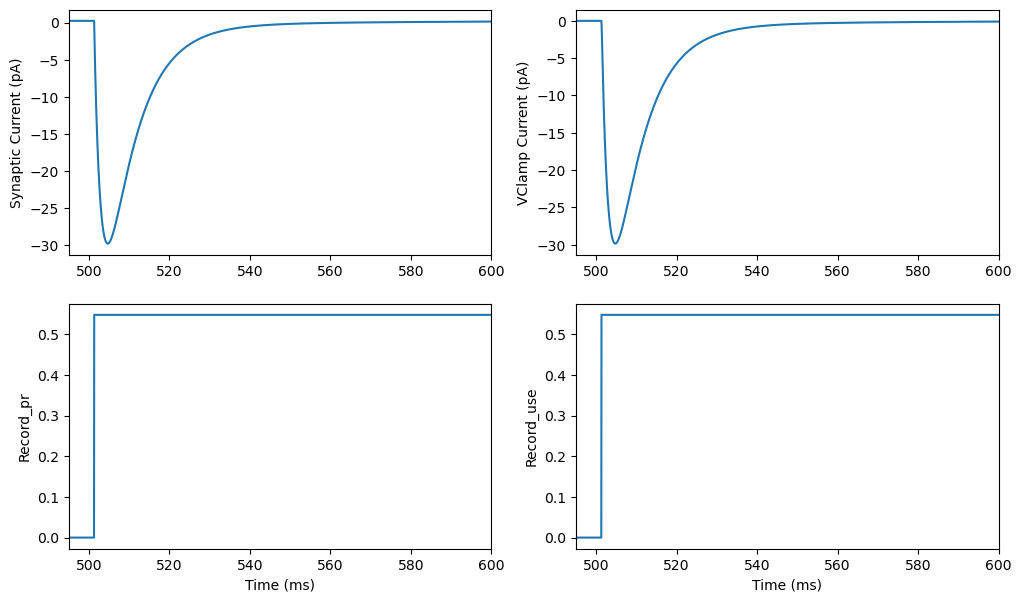

('baseline', -0.0002407732493736603)
('sign', -1.0)
('latency', 1.35)
('amp', 0.02984512930633798)
('rise_time', 1.9000000000000001)
('decay_time', 8.992345075764867)
('half_width', 11.4)
Current Integral in pA*ms: -238.10


In [ ]:
from bmtool.synapses import SynapseOptimizer
# Create the optimizer
optimizer = SynapseOptimizer(tuner)

# Define parameter bounds these can be any range variable you wish to tune
param_bounds = {
    'Dep': (0, 200.0),
    'Fac': (0, 400.0),
    'Use': (0.1, 1.0),
    'tau_r_AMPA': (1,4), # tau r needs to be less than tau d so be careful
    'tau_d_AMPA': (5,20)
}

# Define target metrics these are the metrics that the tuner will try to automatic get the synapse to respond with
# max amps is an absolute value
target_metrics = {
    'induction': -0.75,
    'ppr': 0.8,
    'recovery': 0.0,
    'max_amplitude': 25,     # note if you get rid of the max amps in the cost function the fit will normally be better. Then you could scale the max amps with the initW
    'rise_time': 2,          # This wont always be the case, but for this synapse Use controls STP and max amps so it can sometimes struggle to fit.
    'decay_time': 9
}

# currently the only metrics in the SynapseOptimizer are 
#            - induction: measure of synaptic facilitation/depression
#            - ppr: paired-pulse ratio
#            - recovery: recovery from facilitation/depression
#            - max_amplitude: maximum synaptic response amplitude
#            - rise_time: time for synaptic response to rise from 20% to 80% of peak
#            - decay_time: time constant of synaptic response decay
#            - latency: synaptic response latency
#            - half_width: synaptic response half-width
#            - baseline: baseline current
#            - amp: peak amplitude from syn_props
def custom_cost(metrics, targets):
    # equal zero unless using train input
    induction_error = (metrics['induction'] - targets['induction']) ** 2
    ppr_error = (metrics['ppr'] - targets['ppr']) ** 2
    recovery_error = (metrics['recovery'] - targets['recovery']) ** 2
    max_amp_errror = (metrics['max_amplitude'] - targets['max_amplitude']) ** 2
    # equal zero unless using SingleEvent
    rise_time_error = (metrics['rise_time'] - targets['rise_time']) ** 2
    decay_time_error = (metrics['decay_time'] - targets['decay_time']) ** 2 

    #return rise_time_error + decay_time_error
    return induction_error + 3 * ppr_error + recovery_error + rise_time_error + decay_time_error #+ 0.5*max_amp_errror

# Run optimization with custom cost function
result = optimizer.optimize_parameters(
    target_metrics=target_metrics,
    param_bounds=param_bounds,
    run_single_event=True,  # Run and use parameters from SingleEvent
    run_train_input=True,   # Run and use parameters from train input 
    train_frequency=50,     # Freq in Hz of train input
    train_delay=250,        # delay in ms of second train
    init_guess='random',    # either random or middle_guess. Random will start the synapse witha random value in the param_bound. Middle guess will pick the middle value in the param_bounds
    cost_function=custom_cost,
    method='SLSQP'          # I believe this will be the fastest method, but you may try others check out https://docs.scipy.org/doc/scipy-1.15.0/reference/generated/scipy.optimize.minimize.html
                            # SLSQP is a gradient based method while nelder-mead is simplex (whatever that means)
)

# Plot results
optimizer.plot_optimization_results(result)

## Extra notes
If there is a need for faster optimization with more parameters or more complex metrics the SynapseOptimize could be modifed to use [jax](https://jax.readthedocs.io/en/latest/index.html) and the [scipy method](https://jax.readthedocs.io/en/latest/_autosummary/jax.scipy.optimize.minimize.html). I did not look into this much as my use case currently only takes around 1 min to optimize. Also for the example provided it is important to note that we are using bounded optimizing methods since the Use parameter can not go above one. If there is a case where the parameters have no upper or lower bounds one could look into other optimizing methods